In [38]:
from myclasses.sql_executor import SQLExecutor
import pandas as pd

if __name__ == "__main__":
    # Create an instance of SQLExecutor
    sql_executor = SQLExecutor()

    # Example SQL query
    query = """
        SELECT 
            (operating_income / ((total_assets  + total_liabilities) * num_beds)) as roe,
            net_income as gross_revenue,
            year,
            ownership,
            ownership_type,
            snfs_in_city,
            ((total_debt / (total_assets + total_liabilities) * num_beds)) as debt_to_equity_ratio,
            tot_fund_balance,
            current_ratio,
            quick_ratio,
            medicare,
            medicaid,
            pct_fixed_assets,
            pct_other_assets,
            (tot_days / tot_bed_days_avail) as fill_rate,
            -- cash,
            chow_last_12mos,
            region,
            state,
            state_lean,
            county_ssa,
            zip,
            tot_discharge_tot,
            def_score,
            fine_tot,
            fine_cnt,
            resfamcouncil,
            sprinkler_status,
            overall_rating,
            quality_rating,
            staffing_rating,
            rn_staffing_rating,
            aidhrd,
            vochrd,
            rnhrd,
            totlichrd,
            tothrd,
            pthrd,
            weighted_all_cycles_score,
            certification,
            snf_avg_stay_len_title_tot,
            pop_over_70,
            over_70_pct,
            has_outpatient,
            bedcert,
            fac_type,
            staff_style,
            totlichrd_to_tot
            
            
        FROM Master
        WHERE 
            roa > -1 
            AND roa < 1 
            AND total_assets > 0
            AND total_liabilities > 0 
            AND operating_income < 15000000 
            AND operating_income > -15000000
            AND gross_revenue < 300000000
            AND operating_income < 300000000
            AND (operating_income / ((total_assets  + total_liabilities) * num_beds)) < 1
            AND (operating_income / ((total_assets  + total_liabilities) * num_beds)) > -1
            
        ORDER BY prov_id; 
        """

    # Execute the query and get the result as a DataFrame
    df = sql_executor.execute_query(query)

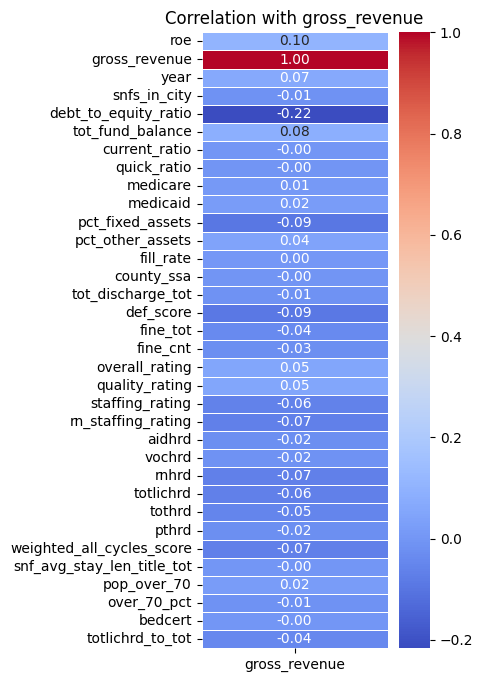

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'operating income' is the name of your y variable
y_variable = 'gross_revenue'

# Concatenate y and X along the columns axis
data = df.select_dtypes(include=['number'])

# Remove 0 columns
non_zero_columns = data.columns[(data != 0).any()]
data = data[non_zero_columns]

# Compute the correlation matrix
correlation_matrix = data.corr()

# Filter correlations with the y variable
y_correlation = correlation_matrix[y_variable]

# Plot heatmap
plt.figure(figsize=(3, 8))
sns.heatmap(y_correlation.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title(f'Correlation with {y_variable}')
plt.show()

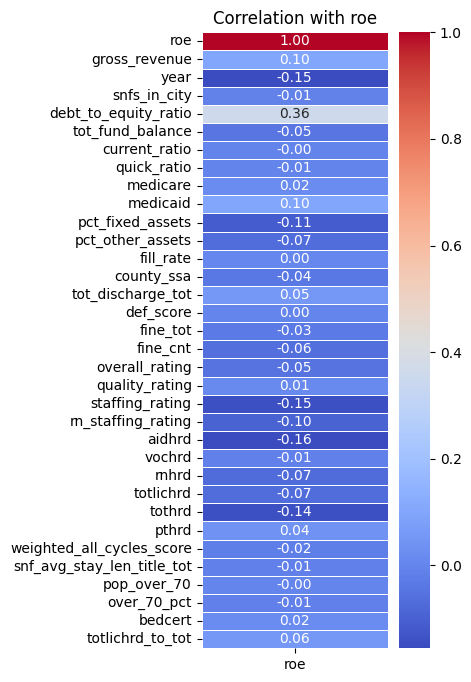

In [40]:
# Assuming 'operating income' is the name of your y variable
y_variable = 'roe'

# Concatenate y and X along the columns axis
data = df.select_dtypes(include=['number'])

# Remove 0 columns
non_zero_columns = data.columns[(data != 0).any()]
data = data[non_zero_columns]

# Compute the correlation matrix
correlation_matrix = data.corr()

# Filter correlations with the y variable
y_correlation = correlation_matrix[y_variable]

# Plot heatmap
plt.figure(figsize=(3, 8))
sns.heatmap(y_correlation.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title(f'Correlation with {y_variable}')
plt.show()

In [41]:
from sklearn.preprocessing import MinMaxScaler


y = pd.DataFrame()
y['gr'] = df['gross_revenue']
y['roe'] = df['roe']

df = df.drop(columns=['gross_revenue','roe'])

# Initialize the scaler
scaler = MinMaxScaler()

# Select numerical columns
quant_cols = df.select_dtypes(include=['number']).columns

# Fill NaNs with Mean
quant_cols_mean = df[quant_cols].median()
df[quant_cols] = df[quant_cols].fillna(quant_cols_mean)

# Apply scaling only to the selected numerical columns
df[quant_cols] = scaler.fit_transform(df[quant_cols])

In [42]:
from sklearn.model_selection import train_test_split

# Select columns where data type is text (object)
text_columns = df.select_dtypes(include=['object']).columns

# Create dummy variables for text columns
df_encoded = pd.get_dummies(df, columns=text_columns)

# Convert all columns to numeric type
df_encoded = df_encoded.apply(pd.to_numeric, errors='coerce')

# Set X
X = df_encoded

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=84)

In [43]:
import xgboost as xgb

# Define XGBoost regressor and set hyperparameters
gr_model = xgb.XGBRegressor(
    booster='gbtree',
    n_estimators=100000,      # Iterations of the model
    learning_rate=0.00065,    # Speed at which the learners optimize
    max_depth=5,            # Depth of the weak learners
    min_child_weight=1,
    device = 'cuda',
    subsample=0.85,
    seed=717,
    colsample_bytree=0.95,
    random_state=42,
    early_stopping_rounds=500,
    eval_metric='rmse',
    objective='reg:squarederror',
    gamma=0.8,              # Increasing this value will make model more conservative
    reg_alpha=0.8,           # Increasing this value will make model more conservative
    reg_lambda=0.8          # Increasing this value will make model more conservative
)

# Train the model with progress printout and early stopping
gr_model.fit(
    X_train, y_train['gr'],
    eval_set=[(X_train, y_train['gr']), (X_test, y_test['gr'])],  # Evaluation set for tracking progress
    verbose=1000
)

[0]	validation_0-rmse:1636287.40708	validation_1-rmse:1818052.13270
[1000]	validation_0-rmse:1508091.13223	validation_1-rmse:1702868.68541
[2000]	validation_0-rmse:1435336.77372	validation_1-rmse:1654850.60544
[3000]	validation_0-rmse:1385240.55682	validation_1-rmse:1627386.48335
[4000]	validation_0-rmse:1343889.17593	validation_1-rmse:1607101.24956
[5000]	validation_0-rmse:1311934.78153	validation_1-rmse:1593231.83886
[6000]	validation_0-rmse:1286267.08023	validation_1-rmse:1583476.09226
[7000]	validation_0-rmse:1264856.59659	validation_1-rmse:1575695.18201
[8000]	validation_0-rmse:1246988.56083	validation_1-rmse:1569222.62945
[9000]	validation_0-rmse:1231221.81177	validation_1-rmse:1563685.65643
[10000]	validation_0-rmse:1217028.66007	validation_1-rmse:1558651.18013
[11000]	validation_0-rmse:1203737.79179	validation_1-rmse:1554017.37809
[12000]	validation_0-rmse:1191594.35685	validation_1-rmse:1550010.59933
[13000]	validation_0-rmse:1180516.11953	validation_1-rmse:1546587.44523
[1400

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device='cuda', early_stopping_rounds=500,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.8, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.00065, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Text(0.5, 1.0, 'XGBoost Learning Curve with rmse')

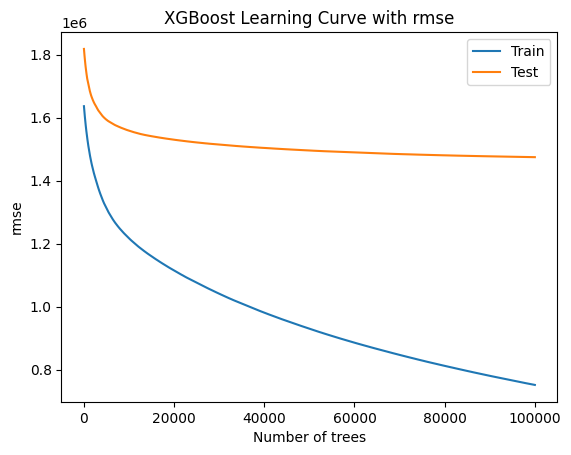

In [44]:
# Get the evaluation results
results = gr_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot the learning curve with RSME
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('rmse')
plt.title('XGBoost Learning Curve with rmse')

In [45]:
from sklearn.metrics import r2_score, median_absolute_error

# Predict on test set
y_pred_gr = gr_model.predict(X_test)

# Median absolute error
mdae = median_absolute_error(y_test['gr'], y_pred_gr)
print("Median absolute error: {:.2f}".format(mdae))

# R² Score (Coefficient of Determination)
r2gr = r2_score(y_test['gr'], y_pred_gr)
print("R² Score (Coefficient of Determination): {:.5f}".format(r2gr))

Median absolute error: 376335.62
R² Score (Coefficient of Determination): 0.34213


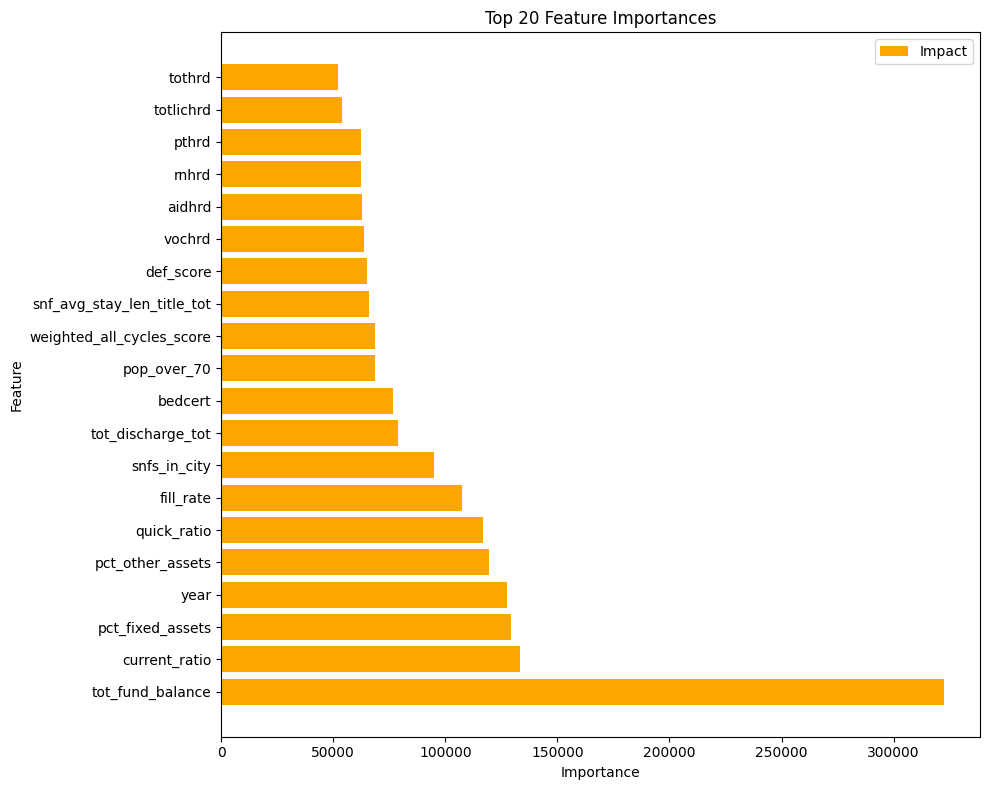

In [46]:
# Get feature importances based on gain
feature_importances  = gr_model.get_booster().get_score()

# Sort the dictionary by importances in descending order
sorted_feature_importance = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Separate positive and negative importances (since gain is inherently positive)
positive_importances  = dict(sorted_feature_importance)

# Extract feature names and importances
positive_features , positive_importances = zip(*positive_importances.items())

# Select only the top 20 features
top_features  = positive_features [:20]
top_importances  = positive_importances [:20]

# Plot positive importances based on gain for top 20 features
plt.figure(figsize=(10, 8))
plt.barh(top_features , top_importances , color='orange', label='Impact')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

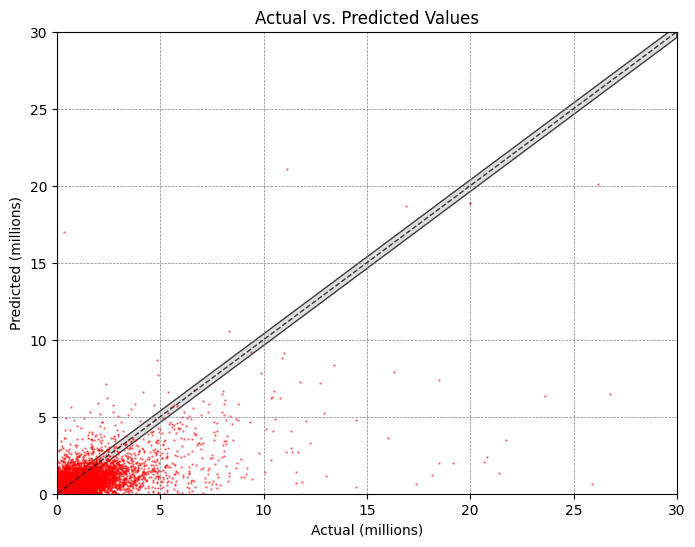

In [47]:
import numpy as np

# Convert values to millions
y_test_millions = y_test['gr'] / 1000000
y_pred_millions = y_pred_gr / 1000000
median_absolute_error_millions = mdae / 1000000

# Calculate residuals
residuals = y_pred_millions - y_test_millions

color = ['red']

plt.figure(figsize=(8, 6))

# Plot the shaded region with darker edges
x = np.linspace(-30, 30, 100)
y1 = x + median_absolute_error_millions
y2 = x - median_absolute_error_millions
plt.fill_between(x, y1, y2, color='lightgray', edgecolor='black', linewidth=1, alpha= .75)

plt.scatter(y_test_millions, y_pred_millions, c=color, alpha=0.5, s=0.5)

# Calculate the 95th percentile of actual and predicted values
y_test_95th_percentile = np.percentile(y_test_millions, 95)
y_pred_95th_percentile = np.percentile(y_pred_millions, 95)

# Plot the diagonal line
plt.plot([-30,30], [-30,30], 'k--', lw=1, alpha=0.75) 



plt.xlabel('Actual (millions)')
plt.ylabel('Predicted (millions)')
plt.title('Actual vs. Predicted Values')

# Set axis limits to show the 95th percentile values
plt.xlim(left=0, right=30)
plt.ylim(bottom=0, top=30)

# Add light gridlines
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

In [48]:
import shap

explainer = shap.Explainer(gr_model)
shap_values = explainer.shap_values(X_train, check_additivity=False)

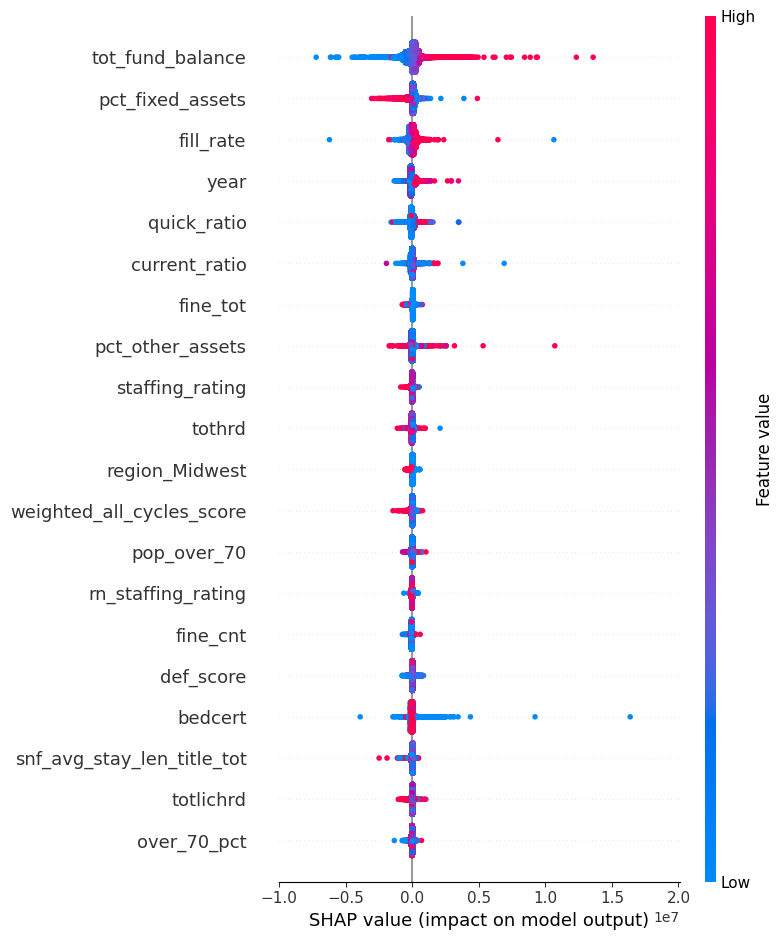

In [49]:
# Find the indices of the top 20 features in the original feature set
top_feature_indices = [X_train.columns.tolist().index(feature) for feature in top_features]

# Select the SHAP values corresponding to the top 20 features
top_shap_values = shap_values[:, top_feature_indices]

# Select only the top 20 features from the training data
top_X_train = X_train.iloc[:, top_feature_indices]

# Calculate shap_values
fig = shap.summary_plot(shap_values, X_train, show=False)
plt.xlim([-10000000, 20100000])  # Set x-axis limit
plt.show()

In [50]:
# Create a new DataFrame with the predictions
y_pred_df = pd.DataFrame({'gr': y_pred_gr}, index=X_test.index)

# Join the predictions DataFrame with X_test
X_test = X_test.join(y_pred_df)
y_test = y_test['roe']

def bin_income(data):
    if data >= np.percentile(y_test, 66):
        return '2'
    if data >= data >= np.percentile(y_test, 33):
        return '1'
    else:
        return '0'
    
y_test = y_test.apply(bin_income)

from sklearn.preprocessing import LabelEncoder

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=100)

# Convert class labels to integers using LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [51]:
# Define XGBoost classifier and set hyperparameters for multiclass classification
roe_model = xgb.XGBClassifier(
    booster='gbtree',
    seed=1001,
    n_estimators=30000,          # Iterations of the model
    learning_rate=0.00035,         # Speed at which the learners optimize
    max_depth=6,                # Depth of the weak learners
    min_child_weight=1, 
    device = 'cuda',    
    subsample=0.85,
    colsample_bytree=0.95,
    random_state=42,
    eval_metric='mlogloss',         # Multiclass logloss for evaluation
    objective='multi:softprob',  # Use softmax for multiclass classification
    num_class=3,                # Number of classes in your dataset
    gamma=0.4,                 # Increasing this value will make model more conservative
    reg_alpha=0.49,             # Increasing this value will make model more conservative
    reg_lambda=0.5,            # Increasing this value will make model more conservative
    early_stopping_rounds=2500
)

# Train the model with progress printout
roe_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Evaluation set for tracking progress
    verbose=1000                                       # Print progress
)

[0]	validation_0-mlogloss:1.09854	validation_1-mlogloss:1.09855
[1000]	validation_0-mlogloss:1.03771	validation_1-mlogloss:1.04786
[2000]	validation_0-mlogloss:0.99407	validation_1-mlogloss:1.01304
[3000]	validation_0-mlogloss:0.96070	validation_1-mlogloss:0.98764
[4000]	validation_0-mlogloss:0.93420	validation_1-mlogloss:0.96828
[5000]	validation_0-mlogloss:0.91266	validation_1-mlogloss:0.95331
[6000]	validation_0-mlogloss:0.89440	validation_1-mlogloss:0.94133
[7000]	validation_0-mlogloss:0.87850	validation_1-mlogloss:0.93140
[8000]	validation_0-mlogloss:0.86429	validation_1-mlogloss:0.92295
[9000]	validation_0-mlogloss:0.85148	validation_1-mlogloss:0.91570
[10000]	validation_0-mlogloss:0.83967	validation_1-mlogloss:0.90932
[11000]	validation_0-mlogloss:0.82878	validation_1-mlogloss:0.90369
[12000]	validation_0-mlogloss:0.81860	validation_1-mlogloss:0.89867
[13000]	validation_0-mlogloss:0.80905	validation_1-mlogloss:0.89423
[14000]	validation_0-mlogloss:0.80008	validation_1-mlogloss:0

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.95, device='cuda', early_stopping_rounds=2500,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.4, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.00035, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None,
              n_estimators=30000, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

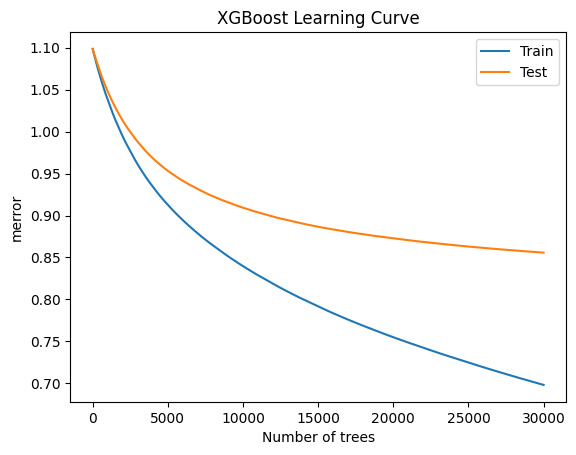

In [52]:
# Get the evaluation results
results = roe_model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Plot the learning curve with multi-logloss
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('merror')
plt.title('XGBoost Learning Curve')
plt.show()

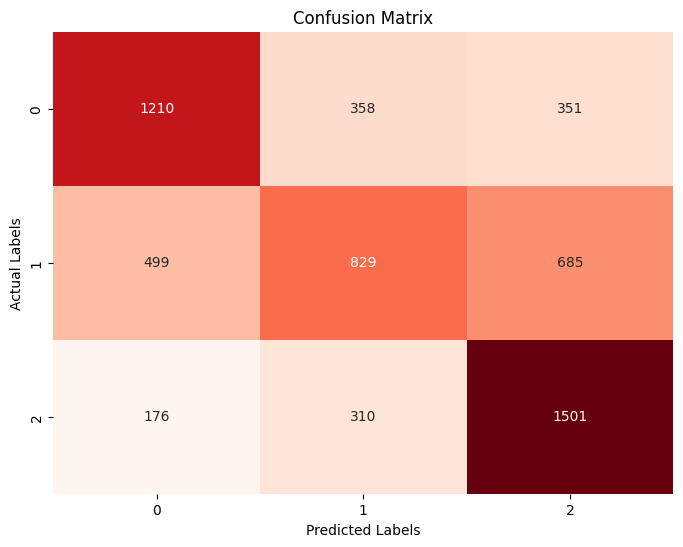

In [53]:
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
y_pred = roe_model.predict(X_test)
y_pred_proba = roe_model.predict_proba(X_test)[:, 1]  

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

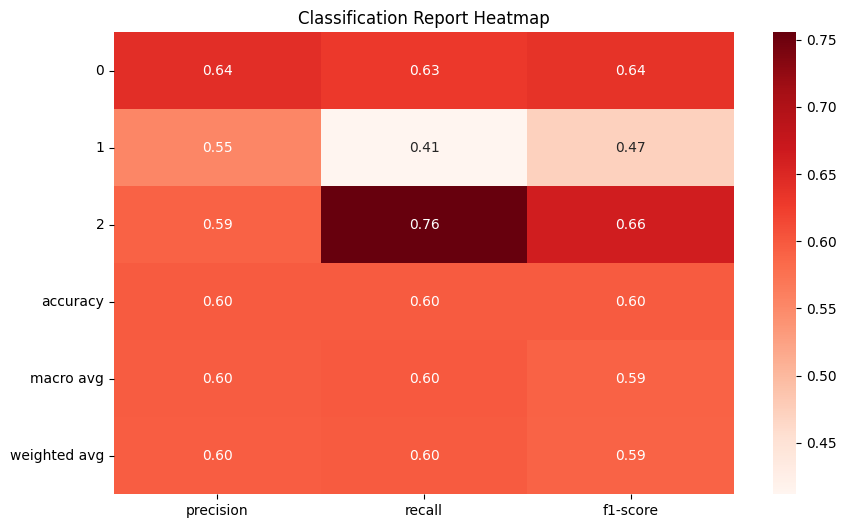

In [54]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate classification report
class_report = classification_report(y_test, y_pred, output_dict=True)

# Convert the classification report to a pandas DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(class_report_df.drop(['support'], axis=1), annot=True, cmap='Reds', fmt=".2f")
plt.title('Classification Report Heatmap')
plt.show()

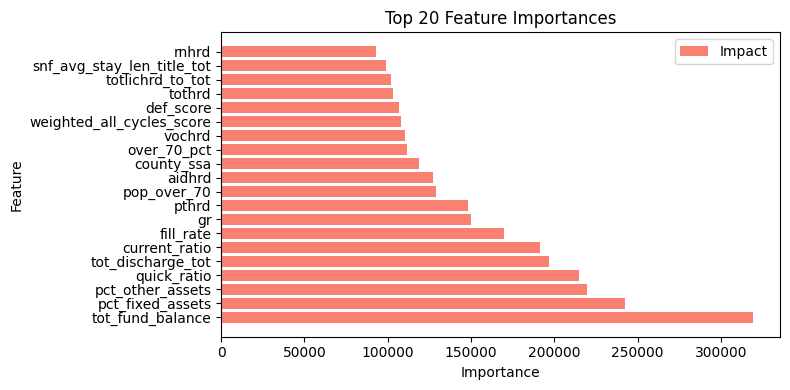

In [55]:
import matplotlib.pyplot as plt

# Get feature importances based on gain
feature_importances  = roe_model.get_booster().get_score()

# Sort the dictionary by importances in descending order
sorted_feature_importance = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Separate positive and negative importances (since gain is inherently positive)
positive_importances  = dict(sorted_feature_importance)

# Extract feature names and importances
positive_features , positive_importances = zip(*positive_importances.items())

# Select only the top 20 features
top_features  = positive_features [:20]
top_importances  = positive_importances [:20]

# Plot positive importances based on gain for top 20 features
plt.figure(figsize=(8, 4))
plt.barh(top_features , top_importances , color='salmon', label='Impact')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()